# Steps 1-3: See bash file

1. Index the sacCer3 genome with `bwa index`
1. Align all seq files with `bwa mem` 
1. Create a sorted bam file with `samtools`, for input to variant callers

# Step 4-7: Variant calling, filtering, decomposing, and effect prediction

4. Varient calling: `freebayes -f -p 1 sacCer3.fa *sorted.bam` 
        note: `-p 1` is necessary for calling varients in haploid genome sequences
5. filter for >0.99 quality: `vcffilter -f "QUAL > 20" > results.vcf`
        (probability > 0.99 is equivalent to phred > 20)
6. Decompose complex haplotypes: `vcfallelicprimitives -kg results.vcf > calls.vcf`
7. Variant effect prediction: `snpeff ann R64-1-1.86 calls.vcf > calls_ann.vcf`

also made file `head -1000 calls_ann.vcf > head_1000_calls.vcf` for pushing to github (see qbl-week2/data/)

# Step 8: Exploratory data analysis through plotting

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

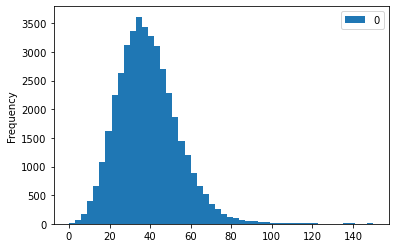

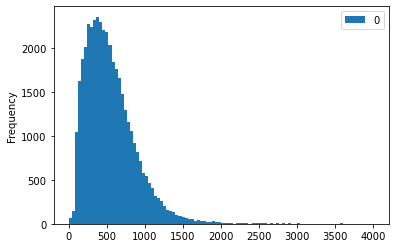

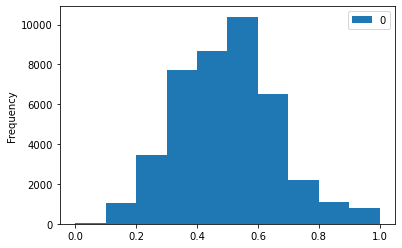

In [5]:
#starting it up...
import numpy as nm
import pandas as pd
import matplotlib.pyplot as plt 

f = open("rawdata/calls_ann.vcf", 'r')

dp = [] #for the read depth distribution (histogram)
gq = [] #for the genotype quality distribution (histogram)
af = [] #for allele frequency spectrum (histogram)
predicted_eff = {} #predicted effect of each variant as determined by snpEff (barplot)

for i,line in enumerate(f): #reads per line
    ann = line.split(";") #splits by semicolon, separating out everything in the FORMAT field
    for j,field in enumerate(ann): 
        if "DP=" in field: #looks for read depth distribution
            if "," in field: #deals with annoying fields with comma separated values
                comma_split = field.split(",") #splits these again
                for k,field2 in enumerate(comma_split):
                    # now have to deal with the first value before the comma: 
                    if "=" in field2: # finds the "="
                        index = field2.index("=") #uses the "=" as an index
                        dp.append(int(field2[index+1:])) #only appends the value after the index
                    else:
                        dp.append(int(field2[:])) #adds each comma separated value to the list
            else: #adds non-annoying fields
                dp.append(int(field[3:])) #starting with after the "DP="
        elif "QA=" in field and "P" not in field: #looks for genome quality value (not "PQA")
            if "," in field: #deals with annoying fields with comma separated values
                comma_split = field.split(",") #splits these again
                for l,field3 in enumerate(comma_split):
                    # now have to deal with the first value before the comma: 
                    if "=" in field3: # finds the "="
                        index = field3.index("=") #uses the "=" as an index
                        gq.append(int(field3[index+1:])) #only appends the value after the index
                    else:
                        gq.append(int(field3[:])) #adds each comma separated value to the list
            else: #adds non-annoying fields
                gq.append(int(field[3:])) #starting with after the "AF="
        elif "AF=" in field and "S" not in field: #looks for allele frequency
            if "," in field: #deals with annoying fields with comma separated values
                comma_split = field.split(",") #splits these again
                for m,field4 in enumerate(comma_split):
                    # now have to deal with the first value before the comma: 
                    if "=" in field4: # finds the "="
                        index = field4.index("=") #uses the "=" as an index
                        af.append(float(field4[index+1:])) #only appends the value after the index
                    else:
                        af.append(float(field4[:])) #adds each comma separated value to the list
            else: #adds non-annoying fields
                af.append(float(field[3:])) #starting with after the "AF="
        else:
            pass
    if "#" in line:
        pass
    else:
        bar_split = line.split("|") #this time use bar to split fields
        for n,field5 in enumerate(bar_split):
            name = bar_split[2] #selects for the third column ("Annotation_Impact")
            predicted_eff.setdefault(name,0) #adds to dictionary
            predicted_eff[name]+=1 #values for dictionary

keys=predicted_eff.keys()
values=predicted_eff.values()
  
dp_df = pd.DataFrame(dp)
dp_hist = dp_df.plot.hist(range=(0,150), bins=50)
display(dp_hist)
gq_df = pd.DataFrame(gq)
gq_hist = gq_df.plot.hist(range=(0,4000), bins=100)
display(gq_hist)
af_df = pd.DataFrame(af)
af_hist = af_df.plot.hist()
display(af_hist)

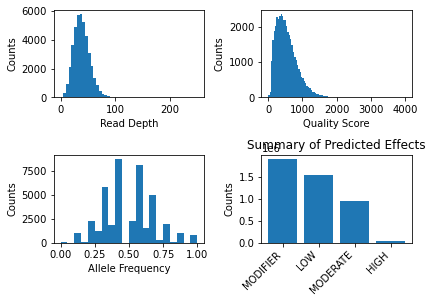

<Figure size 432x288 with 0 Axes>

In [14]:
# make four-panel (2x2) subplots

fig, ax = plt.subplots(2,2)

ax[1,1].bar(keys,values)
ax[1,1].set_title("Summary of Predicted Effects")
ax[1,1].set_ylabel("Counts")

ax[0][0].hist(dp,range=(0,100),bins=50)
ax[0][0].set_ylabel("Counts")
ax[0][0].set_xlabel("Read Depth")

ax[0][1].hist(gq,range=(0,2000),bins=100)
ax[0][1].set_ylabel("Counts")
ax[0][1].set_xlabel("Quality Score")

ax[1][0].hist(af)
ax[1][0].set_ylabel("Counts")
ax[1][0].set_xlabel("Allele Frequency")

fig.tight_layout()

plt.xticks(rotation=45, ha='right')

plt.show()
plt.savefig("sacCer3_var.png")
